## Demand Forecasting Pipeline
Setting up basics for forecasting pipeline

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    # Filter out zero actual values to avoid division by zero
    mask = actual != 0
    actual, pred = actual[mask], pred[mask]
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Reading in Data


In [3]:
df = pd.read_csv('quik_data_all.csv')
df.columns = df.columns.str.lower()
df['order_received_timestamp'] = pd.to_datetime(df['order_received_timestamp'], errors='coerce')


In [4]:
min(df['order_received_timestamp']), max(df['order_received_timestamp'])

(Timestamp('2023-12-01 00:00:00'), Timestamp('2024-02-29 23:40:00'))

In [5]:
df.head()

,merchant_id,order_received_timestamp,order_count
0,merchant_1,2023-12-01 00:00:00,1
1,merchant_1,2023-12-01 00:20:00,2
2,merchant_1,2023-12-01 00:40:00,3
3,merchant_1,2023-12-01 01:00:00,2
4,merchant_1,2023-12-01 01:20:00,3


Aggregating the dataset to the "merchant" and "orders" daily level so that we can have high volume metrics for demand forecasting throughout the region. 

In [6]:
agg_df = df.groupby(['order_received_timestamp', 'merchant_id']).agg({'order_count': 'sum'}).reset_index().sort_values(['merchant_id', 'order_received_timestamp']) #groups the data frame
#(where segment corresponds to merchant, timestamp to date, and target to orders


In [7]:
agg_df.head()

,order_received_timestamp,merchant_id,order_count
0,2023-12-01 00:00:00,merchant_1,1
7,2023-12-01 00:20:00,merchant_1,2
15,2023-12-01 00:40:00,merchant_1,3
24,2023-12-01 01:00:00,merchant_1,2
33,2023-12-01 01:20:00,merchant_1,3


In [8]:
agg_df.tail()

,order_received_timestamp,merchant_id,order_count
70659,2024-02-29 22:20:00,merchant_9,1
70671,2024-02-29 22:40:00,merchant_9,1
70682,2024-02-29 23:00:00,merchant_9,2
70691,2024-02-29 23:20:00,merchant_9,0
70699,2024-02-29 23:40:00,merchant_9,2


In [9]:
total_orders_df = agg_df.pivot(index='order_received_timestamp', columns='merchant_id', values='order_count')
total_orders_df.tail()

merchant_id,merchant_1,merchant_10,merchant_11,merchant_12,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,merchant_7,merchant_8,merchant_9
order_received_timestamp,,,,,,,,,,,,
2024-02-29 22:20:00,3.00,4.00,0.00,1.00,0.00,1.00,1.00,2.00,1.00,4.00,5.00,1.00
2024-02-29 22:40:00,1.00,5.00,2.00,0.00,2.00,1.00,4.00,1.00,2.00,3.00,1.00,1.00
2024-02-29 23:00:00,1.00,3.00,1.00,1.00,2.00,3.00,3.00,2.00,1.00,NaN,1.00,2.00
2024-02-29 23:20:00,1.00,2.00,0.00,NaN,4.00,1.00,2.00,0.00,NaN,NaN,3.00,0.00
2024-02-29 23:40:00,2.00,3.00,1.00,NaN,1.00,1.00,NaN,1.00,NaN,NaN,1.00,2.00


In [10]:
# for column in total_orders_df.columns:
#     plt.figure(figsize=(10, 4))  
#     plt.plot(total_orders_df.index, total_orders_df[column], marker='o', linestyle='-')  
#     plt.title(f"Order Trend for {column}")
#     plt.xlabel('Timestamp')
#     plt.ylabel('Number of Orders')
#     plt.grid(True)  
#     plt.xticks(rotation=45)  
#     plt.tight_layout()  
#     plt.show()

In [11]:
total_orders_df = total_orders_df[total_orders_df.index >= '2023-12-01']


In [12]:
missing_data(total_orders_df)

,Total,Percent,Types
merchant_id,,,
merchant_1,25,0.38,float64
merchant_10,23,0.35,float64
merchant_11,3285,50.14,float64
merchant_12,4573,69.80,float64
merchant_2,0,0.00,float64
merchant_3,0,0.00,float64
merchant_4,4,0.06,float64
merchant_5,0,0.00,float64
merchant_6,3,0.05,float64


In [13]:
total_orders_df.fillna(0, inplace=True) #filling nan values with zeros

# or filling NaN values with the mean of each column
#total_orders_df.fillna(total_orders_df.mean(), inplace=True)

missing_data(total_orders_df)

,Total,Percent,Types
merchant_id,,,
merchant_1,0,0.00,float64
merchant_10,0,0.00,float64
merchant_11,0,0.00,float64
merchant_12,0,0.00,float64
merchant_2,0,0.00,float64
merchant_3,0,0.00,float64
merchant_4,0,0.00,float64
merchant_5,0,0.00,float64
merchant_6,0,0.00,float64


#### Let's group these different categories by the volume of data. The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative).

### Category Grouping

In [14]:
#lets break it down by thirds for low, mid, high
avg_daily_orders = total_orders_df.apply(np.mean, axis=0).sort_values() #typical order volume per merchant across all timestamps.

low, mid = np.percentile(avg_daily_orders, [33, 66]) #thresholds for low, mid, and high order volumes.


In [15]:
# Create lists of merchants based on order volume categories
low_vol_columns = list(avg_daily_orders[avg_daily_orders <= low].index)
mid_vol_columns = list(avg_daily_orders[(avg_daily_orders > low) & (avg_daily_orders < mid)].index)
high_vol_columns = list(avg_daily_orders[avg_daily_orders >= mid].index)



In [16]:
high_vol_columns

['merchant_10', 'merchant_1', 'merchant_4', 'merchant_5']

In [17]:
# plt.figure(figsize=(12, 6))  
# for merchant in low_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for Low Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best')  
# plt.grid(True)  
# plt.xticks(rotation=45)  
# plt.tight_layout() 
# plt.show()

In [18]:
# plt.figure(figsize=(12, 6)) 
# for merchant in mid_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for Mid Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best', bbox_to_anchor=(1.1, 1.05))  # Positioning the legend outside the plot area
# plt.grid(True)  # Adding a grid for better readability
# plt.xticks(rotation=30)  
# plt.tight_layout() 
# plt.show()

In [19]:
# plt.figure(figsize=(12, 6))  # Set a suitable figure size
# for merchant in high_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for High Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best', bbox_to_anchor=(1.1, 1.05))  # Properly title the legend and adjust its position
# plt.xticks(rotation=30)
# plt.grid(True)  # Optionally add a grid
# plt.tight_layout()  # Adjust layout
# plt.show()

### Let's test things out with a high volume metric first to see if things work. Let's test with "Merchant_5"

In [20]:
#setting variables
feature = 'merchant_5' #a high volume merchant
prediction_days = 1 



In [21]:
df = total_orders_df[[feature]].reset_index()
df.head()

merchant_id,order_received_timestamp,merchant_5
0,2023-12-01 00:00:00,1.00
1,2023-12-01 00:20:00,4.00
2,2023-12-01 00:40:00,2.00
3,2023-12-01 01:00:00,1.00
4,2023-12-01 01:20:00,1.00


In [22]:
holiday = pd.DataFrame([])
uae_holidays = holidays.country_holidays('AE')

# Fetch holidays for UAE for the years 2023 and 2024
for date_, name in sorted(holidays.AE(years=[2023, 2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "UAE-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head(10)
#holiday.tail(10)



C:\Users\Nourhan\AppData\Local\Temp\ipykernel_23848\2174945176.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


,ds,holiday,lower_window,upper_window
0,2023-01-01,UAE-Holidays,-2,1
1,2023-04-20,UAE-Holidays,-2,1
2,2023-04-21,UAE-Holidays,-2,1
3,2023-04-22,UAE-Holidays,-2,1
4,2023-04-23,UAE-Holidays,-2,1
5,2023-06-27,UAE-Holidays,-2,1
6,2023-06-28,UAE-Holidays,-2,1
7,2023-06-29,UAE-Holidays,-2,1
8,2023-06-30,UAE-Holidays,-2,1
9,2023-07-21,UAE-Holidays,-2,1


https://pypi.org/project/holidays/

In [23]:
print(df.tail(5)) 


merchant_id order_received_timestamp  merchant_5
6547             2024-02-29 22:20:00        2.00
6548             2024-02-29 22:40:00        1.00
6549             2024-02-29 23:00:00        2.00
6550             2024-02-29 23:20:00        0.00
6551             2024-02-29 23:40:00        1.00


m = Prophet(growth='linear',
            changepoint_range = changepoint_range,
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            seasonality_mode='multiplicative',
            holidays=holiday)

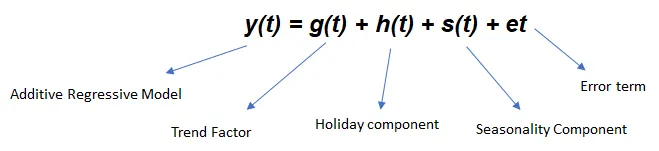

[Timeseries From Scratch article](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.) will show you the breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.

In [24]:
#df.columns

In [25]:
# #PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'order_received_timestamp': 'ds', feature: 'y'})
df_copy['y'] = pd.to_numeric(df_copy['y'])
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

# Set forecast start date
forecast_start_dt = date(2024, 2, 24)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
#print("Forecast start date:", forecast_start_date)

# # Create training set
train_set = df_copy[(df_copy['ds'] < forecast_start_date)] #limit it to everything before that

#train_set.head()

if train_set['y'].notna().sum() < 2:
    print("Error: Not enough non-NaN rows in the training set.")

# Initialize and train the Prophet model
m = Prophet()

m.fit(train_set)

# Create future DataFrame with 20-minute intervals for the specified number of days
future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
fcst_prophet_train = m.predict(future)

# Filter to get the forecasted data
filter = fcst_prophet_train['ds'] >= forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]

17:10:34 - cmdstanpy - INFO - Chain [1] start processing
17:10:34 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
predicted_df.head(10)

,ds,yhat
6120,2024-02-24 00:00:00,-2.62
6121,2024-02-24 00:20:00,-2.86
6122,2024-02-24 00:40:00,-2.98
6123,2024-02-24 01:00:00,-2.93
6124,2024-02-24 01:20:00,-2.67
6125,2024-02-24 01:40:00,-2.17
6126,2024-02-24 02:00:00,-1.42
6127,2024-02-24 02:20:00,-0.41
6128,2024-02-24 02:40:00,0.85
6129,2024-02-24 03:00:00,2.33


<b> variable considerations for prophet model: </b> growth, changepoint_prior_scale, changepoint_range, yearly/weekly/daily seasonality, seasonality mode, holidays

In [27]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [28]:
# # Remove rows with NaN values in ytrue
# predicted_df = predicted_df.dropna(subset=['ytrue'])

# # Filter out rows where ytrue is zero
# predicted_df = predicted_df[predicted_df['ytrue'] != 0]


In [29]:
predicted_df.head()

,ds,yhat,ytrue
0,2024-02-24 00:00:00,-2.62,1.00
1,2024-02-24 00:20:00,-2.86,1.00
2,2024-02-24 00:40:00,-2.98,0.00
3,2024-02-24 01:00:00,-2.93,0.00
4,2024-02-24 01:20:00,-2.67,0.00


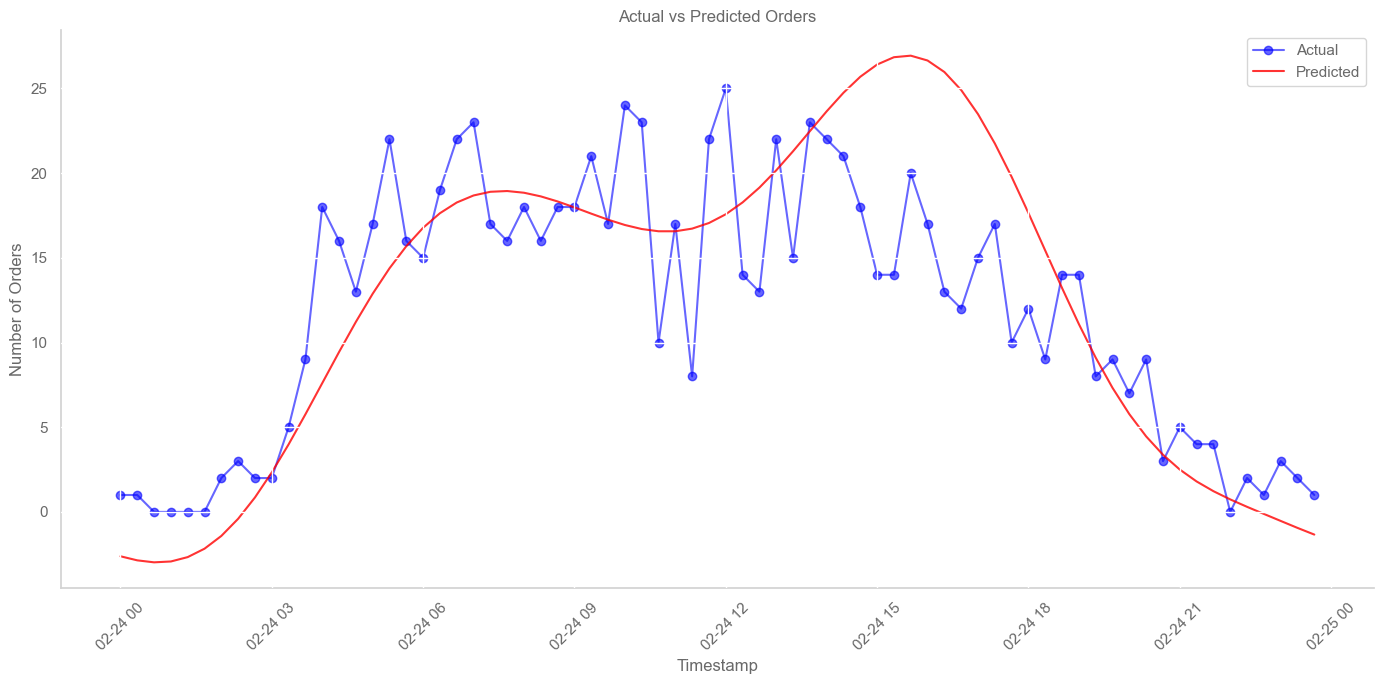

In [30]:
# Plotting the results
plt.figure(figsize=(14, 7))  # Adjust the figure size as needed

# Plot actual values
plt.plot(predicted_df['ds'], predicted_df['ytrue'], label='Actual', color='blue', marker='o', linestyle='-', alpha=0.6)

# Plot predicted values
plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', color='red', linestyle='-', alpha=0.8)

# Add title and labels
plt.title('Actual vs Predicted Orders')
plt.xlabel('Timestamp')
plt.ylabel('Number of Orders')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot

In [31]:
print("Accuracy Score: ")
100 - mape(predicted_df['ytrue'], predicted_df['yhat'])


Accuracy Score: 


44.26366909012698

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(predicted_df['ytrue'], predicted_df['yhat'])
rmse = mean_squared_error(predicted_df['ytrue'], predicted_df['yhat'], squared=False)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 4.08
RMSE: 5.27


c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Cross Validation with Prophet
Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).

In [33]:
print(forecast_start_date)
print(fcst_prophet_train['ds'].min(), fcst_prophet_train['ds'].max())


2024-02-24
2023-12-01 00:00:00 2024-02-24 23:40:00


In [34]:
# Initialize and train the Prophet model
m = Prophet()
m.fit(train_set)

# Cross-validation parameters
initial = '10 days'  
period = '7 day'    
horizon = '1 day'  

df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)


# short-term forecast accuracy is critical.

17:10:37 - cmdstanpy - INFO - Chain [1] start processing
17:10:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/11 [00:00<?, ?it/s]17:10:38 - cmdstanpy - INFO - Chain [1] start processing
17:10:38 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 1/11 [00:00<00:02,  4.29it/s]17:10:38 - cmdstanpy - INFO - Chain [1] start processing
17:10:38 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:00<00:02,  3.81it/s]17:10:38 - cmdstanpy - INFO - Chain [1] start processing
17:10:38 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 3/11 [00:00<00:02,  3.40it/s]17:10:39 - cmdstanpy - INFO - Chain [1] start processing
17:10:39 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:01<00:02,  2.97it/s]17:10:39 - cmdstanpy - INFO - Chain [1] start processing
17:10:39 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 5/11 [00:01<00:02,  2.83it/s]17:10:39 - cmdstanpy - INFO - Chain [1] start processi

In [35]:
print(df_cv.head())
print(df_cv.tail())
print(df_cv['ds'].min(), df_cv['ds'].max())


                   ds  yhat  yhat_lower  yhat_upper    y              cutoff
0 2023-12-15 00:00:00 -0.87       -7.49        6.07 1.00 2023-12-14 23:40:00
1 2023-12-15 00:20:00 -1.25       -7.56        5.99 2.00 2023-12-14 23:40:00
2 2023-12-15 00:40:00 -1.50       -8.42        5.36 3.00 2023-12-14 23:40:00
3 2023-12-15 01:00:00 -1.58       -8.41        5.13 2.00 2023-12-14 23:40:00
4 2023-12-15 01:20:00 -1.43       -8.30        5.68 3.00 2023-12-14 23:40:00
                     ds  yhat  yhat_lower  yhat_upper    y              cutoff
787 2024-02-23 22:20:00 -1.22       -8.61        6.22 0.00 2024-02-22 23:40:00
788 2024-02-23 22:40:00 -1.61       -8.86        5.88 4.00 2024-02-22 23:40:00
789 2024-02-23 23:00:00 -2.00       -9.40        5.74 1.00 2024-02-22 23:40:00
790 2024-02-23 23:20:00 -2.39       -9.75        4.84 3.00 2024-02-22 23:40:00
791 2024-02-23 23:40:00 -2.76      -10.02        4.79 1.00 2024-02-22 23:40:00
2023-12-15 00:00:00 2024-02-23 23:40:00


In [37]:
df_p = performance_metrics(df_cv)
df_p.head()



,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 02:40:00,22.25,4.72,3.98,1.50,1.60,0.85
1,0 days 03:00:00,21.53,4.64,3.88,1.30,1.48,0.85
2,0 days 03:20:00,21.40,4.63,3.88,1.01,1.36,0.86
3,0 days 03:40:00,21.24,4.61,3.82,0.80,1.20,0.86
4,0 days 04:00:00,20.88,4.57,3.75,0.60,1.02,0.86


In [38]:
df_p.tail()

,horizon,mse,rmse,mae,mdape,smape,coverage
60,0 days 22:40:00,20.51,4.53,3.66,0.56,0.85,0.90
61,0 days 23:00:00,20.31,4.51,3.61,0.57,0.90,0.90
62,0 days 23:20:00,18.84,4.34,3.42,0.71,0.95,0.91
63,0 days 23:40:00,18.64,4.32,3.37,0.71,1.01,0.91
64,1 days 00:00:00,17.90,4.23,3.36,0.78,1.12,0.92


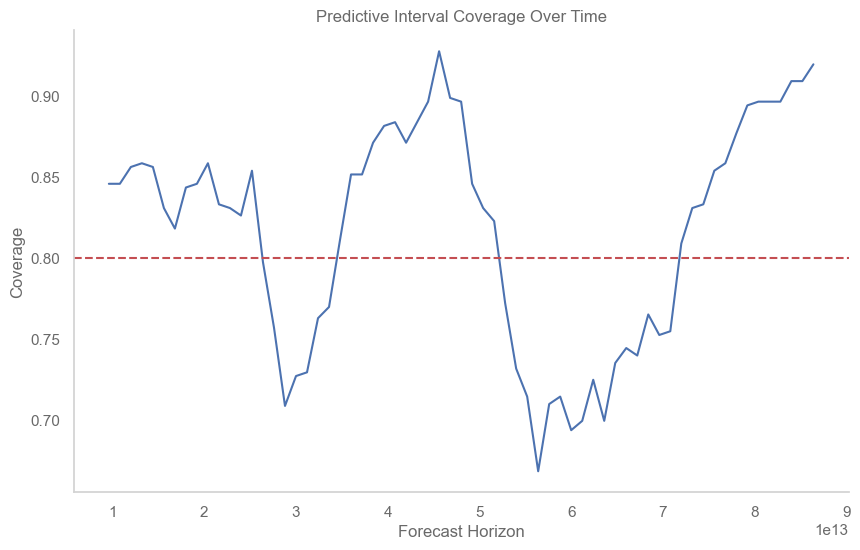

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(df_p['horizon'], df_p['coverage'])
plt.xlabel('Forecast Horizon')
plt.ylabel('Coverage')
plt.title('Predictive Interval Coverage Over Time')
plt.axhline(y=0.8, color='r', linestyle='--')  # Assuming 80% predictive interval
plt.show()


In [ ]:
df_cv['mae'] = abs(df_cv['y'] - df_cv['yhat'])
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y']
df_cv.sort_values('mae', ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mae,overestimate
91,2023-12-22 06:20:00,24.06,17.29,31.30,40.00,2023-12-21 23:40:00,15.94,False
329,2024-01-12 13:40:00,30.37,23.20,37.35,15.00,2024-01-11 23:40:00,15.37,True
190,2023-12-29 15:20:00,30.15,23.48,37.29,45.00,2023-12-28 23:40:00,14.85,False
118,2023-12-22 15:20:00,33.61,27.05,40.73,19.00,2023-12-21 23:40:00,14.61,True
273,2024-01-05 19:00:00,19.20,12.49,26.17,5.00,2024-01-04 23:40:00,14.20,True
85,2023-12-22 04:20:00,13.04,6.33,19.60,27.00,2023-12-21 23:40:00,13.96,False
665,2024-02-16 05:40:00,10.30,2.33,17.76,24.00,2024-02-15 23:40:00,13.70,False
660,2024-02-16 04:00:00,1.97,-5.39,9.57,15.00,2024-02-15 23:40:00,13.03,False
187,2023-12-29 14:20:00,28.00,20.86,34.17,15.00,2023-12-28 23:40:00,13.00,True
713,2024-02-16 21:40:00,-4.76,-12.29,3.12,8.00,2024-02-15 23:40:00,12.76,False


In [43]:
#df_cv

In [44]:
# print("Train set shape:", train_set.shape)
# print(train_set.head())
# print("Cross-validation results:", df_cv.head())
# print("Performance metrics:", df_p.head())


Train set shape: (6120, 2)
merchant_id                  ds    y
0           2023-12-01 00:00:00 1.00
1           2023-12-01 00:20:00 4.00
2           2023-12-01 00:40:00 2.00
3           2023-12-01 01:00:00 1.00
4           2023-12-01 01:20:00 1.00
Cross-validation results:                    ds  yhat  yhat_lower  yhat_upper    y              cutoff  \
0 2023-12-15 00:00:00 -0.87       -7.49        6.07 1.00 2023-12-14 23:40:00   
1 2023-12-15 00:20:00 -1.25       -7.56        5.99 2.00 2023-12-14 23:40:00   
2 2023-12-15 00:40:00 -1.50       -8.42        5.36 3.00 2023-12-14 23:40:00   
3 2023-12-15 01:00:00 -1.58       -8.41        5.13 2.00 2023-12-14 23:40:00   
4 2023-12-15 01:20:00 -1.43       -8.30        5.68 3.00 2023-12-14 23:40:00   

   mae  overestimate  
0 1.87         False  
1 3.25         False  
2 4.50         False  
3 3.58         False  
4 4.43         False  
Performance metrics:           horizon   mse  rmse  mae  mdape  smape  coverage
0 0 days 02:40:00 22.25  4

In [45]:
#here

Optimizing for merchant_5.  <b>  hypertune the model! </b>

In [46]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='10 days', period='7 days', horizon = '1 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses



17:10:44 - cmdstanpy - INFO - Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing
17:10:51 - cmdstanpy - INFO - Chain [1] start processing
17:10:51 - cmdstanpy - INFO - Chain [1] done processing
17:10:55 - cmdstanpy - INFO - Chain [1] start processing
17:10:56 - cmdstanpy - INFO - Chain [1] done processing
17:11:01 - cmdstanpy - INFO - Chain [1] start processing
17:11:01 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing
17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:16 - cmdstanpy - INFO - Chain [1] start processing
17:11:16 - cmdstanpy - INFO - Chain [1] done processing
17:11:21 - cmdstanpy - INFO - Chain [1] start processing
17:11:22 - cmdstanpy - INFO - Chain [1] done processing
17:11:26 - cmdstanpy - INFO - Chain [1] start processing
17:11:27 - cmdstanpy - INFO - Chain [1]

In [47]:
df_p


,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,28.07,5.30,4.31,0.28,0.55,0.82


In [48]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale  rmse
0                      0.00                     0.01  5.12
1                      0.00                     0.10  5.26
2                      0.00                     1.00  5.26
3                      0.00                    10.00  5.28
4                      0.01                     0.01  5.14
5                      0.01                     0.10  5.29
6                      0.01                     1.00  5.30
7                      0.01                    10.00  5.29
8                      0.10                     0.01  5.15
9                      0.10                     0.10  5.30
10                     0.10                     1.00  5.30
11                     0.10                    10.00  5.30
12                     0.50                     0.01  5.13
13                     0.50                     0.10  5.29
14                     0.50                     1.00  5.29
15                     0.50                    10.00  5.

In [49]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.00,0.01,5.12
12,0.50,0.01,5.13
4,0.01,0.01,5.14
8,0.10,0.01,5.15
2,0.00,1.00,5.26
1,0.00,0.10,5.26
3,0.00,10.00,5.28
5,0.01,0.10,5.29
13,0.50,0.10,5.29
14,0.50,1.00,5.29


In [50]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale   0.00
seasonality_prior_scale   0.01
rmse                      5.12
Name: 0, dtype: float64

In [51]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01,
 'rmse': 5.122603853861617}

In [52]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])


In [53]:
print(df_copy.columns)


Index(['ds', 'ytrue'], dtype='object')


In [54]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
#mape(predicted_df['ytrue'], predicted_df['yhat'])
np.sqrt(np.mean((predicted_df['ytrue'] - predicted_df['yhat'])**2))



17:12:49 - cmdstanpy - INFO - Chain [1] start processing
17:12:49 - cmdstanpy - INFO - Chain [1] done processing


5.0654168142943305

In [55]:
#predicted_df

In [56]:
# import matplotlib.pyplot as plt

# # Assuming the previous steps have been done correctly and predicted_df is ready
# # Make sure to run this after the RMSE calculation and the merging step

# # Plot the results
# plt.figure(figsize=(14, 7))  # Set the size of the plot

# # Plot actual values
# plt.plot(predicted_df['ds'], predicted_df['ytrue'], label='Actual', color='blue', marker='o', linestyle='-', alpha=0.6)

# # Plot predicted values
# plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', color='red', linestyle='-', alpha=0.8)

# # Add title and labels with more descriptive text including RMSE value
# rmse = np.sqrt(np.mean((predicted_df['ytrue'] - predicted_df['yhat'])**2))
# plt.title(f'Actual vs Predicted Orders (RMSE: {rmse:.2f})')
# plt.xlabel('Date')
# plt.ylabel('Order Quantity')

# # Add a legend to the plot
# plt.legend()

# # Add a grid for easier visualization
# plt.grid(True)

# # Rotate the date labels for better readability
# plt.xticks(rotation=45)

# # Use tight_layout to automatically adjust subplot params for the plot to fit into th


In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate additional metrics
mae = mean_absolute_error(predicted_df['ytrue'], predicted_df['yhat'])
rmse = mean_squared_error(predicted_df['ytrue'], predicted_df['yhat'], squared=False)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 3.97
RMSE: 5.07


c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [58]:
# # Plotting the results
# plt.figure(figsize=(14, 7))  # Adjust the figure size as needed

# # Plot actual values
# plt.plot(predicted_df['ds'], predicted_df['ytrue'], label='Actual', color='blue', marker='o', linestyle='-', alpha=0.6)

# # Plot predicted values
# plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', color='red', linestyle='-', alpha=0.8)

# # Add title and labels
# plt.title('Actual vs Predicted Orders')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')

# # Add legend
# plt.legend()

# # Add grid
# plt.grid(True)

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Adjust layout
# plt.tight_layout()

# # Show plot

In [59]:
# import numpy as np

# # Example DataFrame for expanded visualization
# data = {
#     'ds': pd.date_range(start='2024-01-01', periods=100, freq='D'),
#     'ytrue': np.random.rand(100) * 100,
#     'yhat': np.random.rand(100) * 100
# }
# predicted_df = pd.DataFrame(data)

# # Ensure 'ds' column is datetime
# predicted_df['ds'] = pd.to_datetime(predicted_df['ds'])

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(predicted_df['ds'], predicted_df['ytrue'], label='Actual', marker='o')
# plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', marker='x')
# plt.xlabel('Date')
# plt.ylabel('Order Count')
# plt.title('Actual vs Predicted Order Counts')
# plt.legend()
# plt.show()


In [60]:
# import matplotlib.pyplot as plt

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(predicted_df['ds'], predicted_df['ytrue'], label='Actual')
# plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Order Count')
# plt.title('Actual vs Predicted Order Counts')
# plt.legend()
# plt.show()


In [61]:
# # Calculate residuals
# predicted_df['residual'] = predicted_df['ytrue'] - predicted_df['yhat']

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.plot(predicted_df['ds'], predicted_df['residual'])
# plt.xlabel('Date')
# plt.ylabel('Residual')
# plt.title('Residuals Over Time')
# plt.show()


In [62]:
# import matplotlib.pyplot as plt

# # Calculate residuals
# predicted_df['residual'] = predicted_df['ytrue'] - predicted_df['yhat']

# # Plot residuals using scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(predicted_df['ds'], predicted_df['residual'], color='blue')  # using scatter here
# plt.xlabel('Date')
# plt.ylabel('Residual')
# plt.title('Residuals Over Time')
# plt.axhline(0, color='red', linestyle='--')  # Adds a horizontal line at zero to indicate no residual
# plt.show()
